In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

# Define a custom dataset class to load image frames
class FrameDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(240, 320)):
        self.data_dir = data_dir
        self.frames = []  # List to store image frames
        self.transform = transform
        self.target_size = target_size

        for label in sorted(os.listdir(data_dir)):
            label_path = os.path.join(data_dir, label)
            if os.path.isdir(label_path):
                for filename in sorted(os.listdir(label_path)):
                    if filename.endswith('.png'):
                        frame_path = os.path.join(label_path, filename)
                        self.frames.append((frame_path, label))

        if len(self.frames) == 0:
            raise ValueError(f"No valid frames found in {data_dir}")

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame_path, label = self.frames[idx]
        frame = Image.open(frame_path).convert("RGB")  # Load frame as PIL Image

        # Resize the frame to target size
        if self.target_size is not None:
            frame = frame.resize(self.target_size)

        if self.transform:
            frame = self.transform(frame)

        return frame, label


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# Initialize dataset and dataloader
data_dir = '/content/drive/MyDrive/Hack/data'
transform = torchvision.transforms.ToTensor()  # Convert images to tensors

dataset = FrameDataset(data_dir, transform=transform)
target_size = (240, 320)  # Set your desired target size

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

dataset = FrameDataset(data_dir, transform=transform, target_size=target_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize autoencoder model and loss function
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch, labels in dataloader:
        batch = batch.to(device)
        recon_batch = model(batch)

        loss = criterion(recon_batch, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'anomaly_detector.pth')


In [61]:
import cv2

class VideoDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(240, 320)):
        self.data_dir = data_dir
        self.frames = []  # List to store video frames
        self.transform = transform
        self.target_size = target_size

        for label in sorted(os.listdir(data_dir)):
            label_path = os.path.join(data_dir, label)
            if os.path.isdir(label_path):
                for filename in sorted(os.listdir(label_path)):
                    if filename.endswith('.avi'):  # Assuming videos are in .mp4 format
                        video_path = os.path.join(label_path, filename)
                        cap = cv2.VideoCapture(video_path)
                        while True:
                            ret, frame = cap.read()
                            if not ret:
                                break
                            self.frames.append((frame, label))
                        cap.release()

        if len(self.frames) == 0:
            raise ValueError(f"No valid frames found in {data_dir}")

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame, label = self.frames[idx]

        # Convert frame to PIL Image
        frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Resize the frame to target size
        if self.target_size is not None:
            frame = frame.resize(self.target_size)

        if self.transform:
            frame = self.transform(frame)

        return frame, label

# Initialize dataset and dataloader
data_dir = '/content/drive/MyDrive/Hack/data'  # Replace with actual path

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

dataset = VideoDataset(data_dir, transform=transform, target_size=target_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize autoencoder model and loss function
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch, labels in dataloader:
        batch = batch.to(device)
        recon_batch = model(batch)

        loss = criterion(recon_batch, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'anomaly_detector.pth')

Epoch [1/10], Loss: 0.0747
Epoch [2/10], Loss: 0.0723
Epoch [3/10], Loss: 0.0704
Epoch [4/10], Loss: 0.0687
Epoch [5/10], Loss: 0.0703
Epoch [6/10], Loss: 0.0717
Epoch [7/10], Loss: 0.0680
Epoch [8/10], Loss: 0.0698
Epoch [9/10], Loss: 0.0690
Epoch [10/10], Loss: 0.0681


In [ ]:
import cv2

class VideoDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(240, 320)):
        self.data_dir = data_dir
        self.frames = []  # List to store video frames
        self.transform = transform
        self.target_size = target_size

        for label in sorted(os.listdir(data_dir)):
            label_path = os.path.join(data_dir, label)
            if os.path.isdir(label_path):
                for filename in sorted(os.listdir(label_path)):
                    if filename.endswith('.avi'):  # Assuming videos are in .avi format
                        video_path = os.path.join(label_path, filename)
                        cap = cv2.VideoCapture(video_path)
                        while True:
                            ret, frame = cap.read()
                            if not ret:
                                break

                            # Ensure frames are resized to target size
                            if self.target_size is not None:
                                frame = cv2.resize(frame, self.target_size)

                            self.frames.append((frame, label))
                        cap.release()

        if len(self.frames) == 0:
            raise ValueError(f"No valid frames found in {data_dir}")

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
      frame, label = self.frames[idx]

      # Convert frame to PIL Image
      frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

      # Resize the frame to target size
      if self.target_size is not None:
          frame = frame.resize(self.target_size)

      if self.transform:
          frame = self.transform(frame)

      # print(f'Frame shape after processing: {frame.shape}')  # Debug print

      return frame, label


# Initialize dataset and dataloader
data_dir = '/content/drive/MyDrive/Hack/data'  # Replace with actual path

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

dataset = VideoDataset(data_dir, transform=transform, target_size=target_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

class AutoencoderWithLSTM(nn.Module):
    def __init__(self, num_lstm_layers=1, lstm_hidden_size=64):
        super(AutoencoderWithLSTM, self).__init__()
        self.num_lstm_layers = num_lstm_layers
        self.lstm_hidden_size = lstm_hidden_size

        # LSTM Layers
        self.lstm = nn.LSTM(input_size=3*240*320,
                            hidden_size=self.lstm_hidden_size,
                            num_layers=self.num_lstm_layers,
                            batch_first=True)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.lstm_hidden_size, 3*240*320),  # Fully connected layer
            nn.ReLU()
        )

    def forward(self, x):
        batch_size, c, h, w = x.size()

        # Reshape for LSTM
        x = x.view(batch_size, 1, -1)

        # LSTM layer
        h0 = torch.zeros(self.num_lstm_layers, x.size(0), self.lstm_hidden_size).to(x.device)
        c0 = torch.zeros(self.num_lstm_layers, x.size(0), self.lstm_hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))

        # Take the output from the last time step
        x = out[:, -1, :]

        x = self.decoder(x)

        # Reshape back to image dimensions
        x = x.view(batch_size, c, h, w)
        return x


# Initialize autoencoder model with LSTM and loss function
model = AutoencoderWithLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}] starting..')
    total_loss = 0.0

    for batch, labels in dataloader:
        batch = batch.to(device)
        recon_batch = model(batch)

        loss = criterion(recon_batch, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'anomaly_detector_with_lstm.pth')

Epoch [1/10] starting..
Epoch [1/10], Loss: 0.1153
Epoch [2/10] starting..
Epoch [2/10], Loss: 0.1066
Epoch [3/10] starting..
Epoch [3/10], Loss: 0.1043
Epoch [4/10] starting..
Epoch [4/10], Loss: 0.1032
Epoch [5/10] starting..
Epoch [5/10], Loss: 0.1028
Epoch [6/10] starting..
Epoch [6/10], Loss: 0.1026
Epoch [7/10] starting..
Epoch [7/10], Loss: 0.1025
Epoch [8/10] starting..
Epoch [8/10], Loss: 0.1025
Epoch [9/10] starting..
Epoch [9/10], Loss: 0.1025
Epoch [10/10] starting..
Epoch [10/10], Loss: 0.1025


# Inference

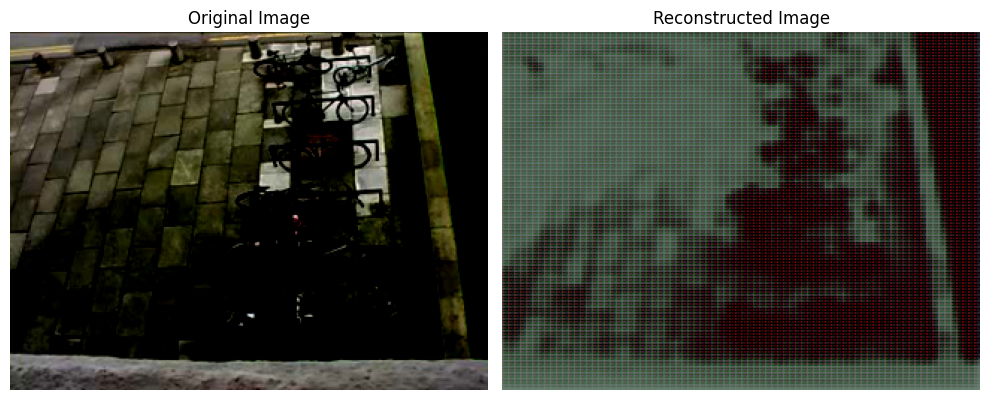

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

# Define the Autoencoder class (same as before)
# ...

# Load the pre-trained model
model = Autoencoder()
model.load_state_dict(torch.load('anomaly_detector.pth'))
model.eval()

# Load and transform a test image
test_image_path = '/content/drive/MyDrive/Hack/data/anomaly/frame_120.png'  # Replace with the actual path
test_image = Image.open(test_image_path).convert("RGB")
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((240, 320)),  # Resize to the same dimensions as the training data
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_image = transform(test_image).unsqueeze(0)  # Add batch dimension

# Pass the image through the autoencoder
with torch.no_grad():
    reconstructed_image = model(test_image)

# Visualize the original and reconstructed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_image.squeeze().permute(1, 2, 0))  # Display the original image
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_image.squeeze().permute(1, 2, 0))  # Display the reconstructed image
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


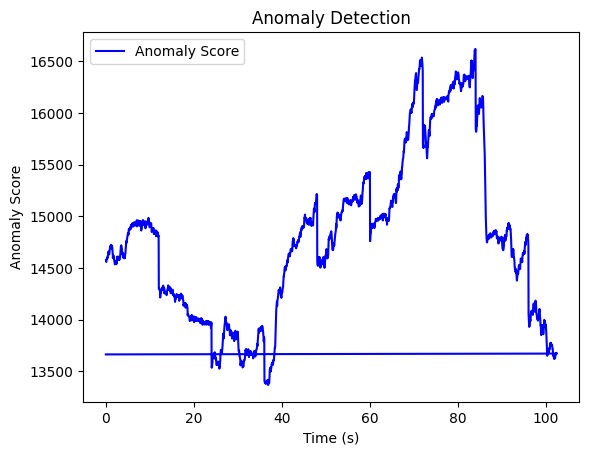

In [62]:
import cv2
import numpy as np

def process_video(model, video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    anomaly_scores = []
    timestamps = []

    for i in range(frame_count):
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (320, 240))
        frame = torchvision.transforms.ToTensor()(frame)
        frame = (frame - 0.5) / 0.5
        frame = frame.unsqueeze(0)

        with torch.no_grad():
            reconstructed_frame = model(frame)

        mse_loss = nn.MSELoss(reduction='none')
        error = mse_loss(frame, reconstructed_frame).sum().item()

        anomaly_scores.append(error)
        timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC) / 1000)  # Convert to seconds

    cap.release()

    return timestamps, anomaly_scores

def plot_anomaly_scores(timestamps, anomaly_scores):
    plt.plot(timestamps, anomaly_scores, label='Anomaly Score', color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Detection')
    plt.legend()
    plt.show()

# Usage
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
model.load_state_dict(torch.load('anomaly_detector.pth'))
model.eval()

video_path = '/content/drive/MyDrive/Hack/data/videos/sample.avi'
timestamps, anomaly_scores = process_video(model, video_path)
plot_anomaly_scores(timestamps, anomaly_scores)


In [60]:
import cv2
import json
import threading
import time

def process_video(model, video_path, json_path):
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    anomaly_scores = []
    timestamps = []

    def update_json():
        while True:
            if timestamps and anomaly_scores:
                data = [{"timestamp": t, "anomaly_score": s} for t, s in zip(timestamps, anomaly_scores)]
                with open(json_path, 'w') as json_file:
                    json.dump(data, json_file)
                time.sleep(5)  # Update every 5 seconds (adjust as needed)

    updater_thread = threading.Thread(target=update_json)
    updater_thread.daemon = True
    updater_thread.start()

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (320, 240))
        frame = torchvision.transforms.ToTensor()(frame)
        frame = (frame - 0.5) / 0.5
        frame = frame.unsqueeze(0)

        with torch.no_grad():
            reconstructed_frame = model(frame)

        mse_loss = nn.MSELoss(reduction='none')
        error = mse_loss(frame, reconstructed_frame).sum().item()

        anomaly_scores.append(error)
        timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC) / 1000)  # Convert to seconds

        # Display the plot
        plot_anomaly_scores(timestamps, anomaly_scores)
        plt.pause(0.01)  # Add a slight delay for display

    cap.release()

def plot_anomaly_scores(timestamps, anomaly_scores):
    plt.plot(timestamps, anomaly_scores, label='Anomaly Score', color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Detection')
    plt.legend()
    plt.show()

# Usage
model = Autoencoder()
model.load_state_dict(torch.load('anomaly_detector.pth'))
model.eval()

video_path = '/content/drive/MyDrive/Hack/data/videos/2023-10-20 11_57_56.h264'
json_path = '/content/drive/MyDrive/Hack/data/anomaly_scores.json'

process_video(model, video_path, json_path)


KeyboardInterrupt: ignored